In [1]:
import numpy as np
from skimage import io
from pathlib import Path
import re
import ants
from skimage.transform import resize
from tqdm import tqdm
from skimage.morphology import skeletonize_3d, binary_dilation, binary_closing
from scipy.ndimage import distance_transform_edt
import tifffile as tif
from scipy.ndimage import binary_fill_holes
import cc3d
from scipy.io import loadmat, savemat
#import skan
import sknw
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy as sp
import vg
from pytransform3d.rotations import matrix_from_axis_angle
import multiprocessing
from scipy.ndimage import convolve as conv
from scipy.stats import multivariate_normal
from skimage import color, data, restoration
from RedLionfishDeconv import doRLDeconvolutionFromNpArrays

# Define connected componnet removal

In [2]:
def remove_small_comps_3d(image, thresh = 500):
    """
    

    Parameters
    ----------
    image : binary np array with uint8 elements
        3d numpy matrix, connected components will be removed form this image
    thresh : int64
        smallest connected components to keep

    Returns
    -------
    np.array with uint8 elements, binary
        binary image with connected components below the threshold removed.

    """
    img_lab, N = cc3d.connected_components(image,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    unique_keep = unique[counts>thresh]
    unique_keep = np.delete(unique_keep,[0])
    img_filt = np.zeros(img_lab.shape).astype('int8')
    img_filt[np.isin(img_lab,unique_keep)] = 1
    return img_filt.astype('uint8')   

def fill_holes(img,thresh=100):
    #res = np.zeros(img.shape)
    for i in np.unique(img)[::-1]:
        _tmp = (img==i)*1.0
        _tmp = _tmp.astype('int8')
        _tmp = remove_small_comps_3d(_tmp,thresh=thresh)
        img[_tmp==1] = i
    res = img.astype('int8')
    return res

# Get mean predictions

In [3]:
directory = Path('matt_preds')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if 'vbm' not in x]

In [4]:
print(files[0])

matt_preds/06162021_45-XYZres288_0001_mean.npy


In [5]:
len(files)

767

# High bias low varience segmentation

With removal of connected components under 500 pixels

In [ ]:
min_prob = 0.75
max_var = 0.1
for file in tqdm(files[:]):
    #if (time.time() - os.path.getmtime(re.sub('mean','seg',file)))/3600>48:
    if not os.path.exists(re.sub('mean','seg',file)):
        mean = np.load(file)
        std = np.load(re.sub('mean','std',file))
        seg = np.zeros(mean.shape[1:])
        seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
        seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
        seg = seg.astype('int8')
        seg = (seg==1)*1
        seg = fill_holes(seg)
        np.save(re.sub('mean','seg',file),seg)
        #savemat(re.sub('mean.npy','seg.mat',file),{'FinalImage':fill_holes(binary_dilation(binary_dilation(seg)))})
        #tif.imwrite(re.sub('mean.npy','seg.tif',file),seg)

# Get distance transform of neuron segmentation

In [ ]:
directory = Path('matt_preds')
files  = directory.glob('*-*_mean.npy')
files = sorted([x.as_posix() for x in files])
#files = [x for x in files if 'vbm' not in x]

In [ ]:
min_prob = 0.75
max_var = 0.1
for file in tqdm(files):
    #if (time.time() - os.path.getmtime(re.sub('mean','seg_nrn_dst',file)))/3600>48:
    if not os.path.exists(re.sub('mean','seg_nrn_dst',file)):
        mean = np.load(file)
        std = np.load(re.sub('mean','std',file))
        seg = np.zeros(mean.shape[1:])
        seg[(mean[1,:,:,:] > min_prob) * (std[1,:,:,:] < max_var)] = 1
        seg[(mean[2,:,:,:] > min_prob) * (std[2,:,:,:] < max_var)] = 2
        seg = seg.astype('int8')
        seg = (seg==2)*1
        np.save(re.sub('mean','seg_nrn',file),seg)
        np.save(re.sub('mean','seg_nrn_dst',file),distance_transform_edt(1-seg))

In [ ]:
#re.sub('mean','seg_nrn_dst',file)

# ANTs registration

## Upsample raw images

In [ ]:
image_path = Path('/home/rozakmat/projects/rrg-bojana/data/THY1-TBI')
images = list(image_path.glob('*?[0-9]/*res*?[0-9].tif'))
images = sorted([x.as_posix() for x in images])
len(images)

In [ ]:
for i in tqdm(range(len(images))[:]):
    if not os.path.exists('matt_preds/'+re.sub('/','-',re.sub('/home/rozakmat/projects/rrg-bojana/data/THY1-TBI/','',images[i]))):
        image = io.imread(images[i])
        if image.shape[0] == 96:
            image = np.swapaxes(image,0,1)
            image = np.swapaxes(image,1,3)
            image = resize(image,(2,507,507,252),preserve_range=True, order=3)
            zeros = np.zeros((1,507,507,252)).astype('uint16')
            image = np.append(image,zeros,axis = 0)
            image = image.astype('float16')
            io.imsave('matt_preds/'+re.sub('/','-',re.sub('/home/rozakmat/projects/rrg-bojana/data/THY1-TBI/','',images[i])),image)

In [ ]:
#'matt_preds/'+re.sub('/','-',re.sub('/home/rozakmat/projects/rrg-bojana/data/THY1-TBI/','',images[i]))

## reshape numpy seg files and resave as tif

In [ ]:
directory_seg = Path('matt_preds')
files_seg  = list(directory_seg.glob('*_seg.npy'))
files_seg = sorted([x.as_posix() for x in files_seg])
#files_seg

In [ ]:
for i in tqdm(range(len(files_seg))):
    if not os.path.exists(re.sub('.npy','.tif',files_seg[i])):
        tmp = np.load(files_seg[i])
        tmp = np.reshape(tmp,(1,507,507,252))
        io.imsave(re.sub('.npy','.tif',files_seg[i]),tmp)

## Register images and transform masks

In [5]:
directory_seg = Path('matt_preds')
images = list(directory_seg.glob('*_0001.tif'))
images = sorted([x.as_posix() for x in images])#[0:2]
#np.random.shuffle(images)
print(len(images))
print(images[0])
i=0

380
matt_preds/06162021_45-XYZres288_0001.tif


In [6]:
#re.sub('_0001','',images[i]) #fix

In [7]:
#re.sub('.tif','_warped.tif',images[i]) #mov

In [8]:
for i in tqdm(range(len(images))):
    #if os.path.exists(re.sub('.tif','_seg.tif',images[i])):
        #if not os.path.exists(re.sub('.tif','_warped.tif',images[i])):
            fix_numpy = io.imread(re.sub('_0001','',images[i]))
            fix_numpy = np.swapaxes(fix_numpy,1,3)
            mov_numpy = io.imread(images[i])
            mov_numpy = np.swapaxes(mov_numpy,1,3)
            break
            fix = ants.from_numpy(np.float32(fix_numpy[0]))
            mov = ants.from_numpy(np.float32(mov_numpy[0]))
            fix_mask = ants.image_read(re.sub('.tif','_seg.tif',re.sub('_0001','',images[i])))
            mov_mask = ants.image_read(re.sub('.tif','_seg.tif',images[i]))
            mytx = ants.registration(fixed = fix,
                                    moving = mov,
                                    type_of_transform = 'Rigid'
                                    )
            warpedmask = ants.apply_transforms(fixed = fix_mask,
                                               moving = mov_mask,
                                               transformlist = mytx['fwdtransforms'],
                                               interpolator = 'nearestNeighbor'
                                              )
            warpedraw_1 = ants.apply_transforms(fixed = fix,
                                                moving = ants.from_numpy(np.float32(mov_numpy[0])),
                                                transformlist = mytx['fwdtransforms'],
                                                interpolator = 'linear'
                                                )
            warpedraw_2 = ants.apply_transforms(fixed = fix,
                                                moving = ants.from_numpy(np.float32(mov_numpy[1])),
                                                transformlist = mytx['fwdtransforms'],
                                                interpolator = 'linear'
                                                )
            mov_numpy[0,:,:,:] = warpedraw_1[:,:,:]
            mov_numpy[1,:,:,:] = warpedraw_2[:,:,:]
            io.imsave(re.sub('seg','seg_warped',re.sub('.tif','_seg.tif',images[i])),warpedmask.numpy())
            io.imsave(re.sub('.tif','_warped.tif',images[i]),mov_numpy)
            io.imsave(re.sub('seg','seg_warped',re.sub('.tif','_seg.tif',re.sub('_0001','',images[i]))),fix_mask.numpy())
            print(2 * np.sum(warpedmask.numpy()*fix_mask.numpy())/(np.sum(warpedmask.numpy())+np.sum(fix_mask.numpy())))

  0%|          | 0/380 [00:01<?, ?it/s]


In [9]:
mov_numpy.shape
#re.sub('seg','seg_warped',re.sub('.tif','_seg.tif',images[i]))

(3, 252, 507, 507)

In [ ]:
#re.sub('.tif','_warped.tif',images[i])
re.sub('seg','seg_warped',re.sub('.tif','_seg.tif',re.sub('_0001','',images[i])))

In [ ]:
#mov_numpy.shape

In [ ]:
#plt.imshow(fix_mask.numpy()[20])

## Save Matlab .mat file of registered images

In [ ]:
directory_seg = Path('matt_preds')
images = list(directory_seg.glob('*_0001_seg_warped.tif'))
images = sorted([x.as_posix() for x in images])[::-1]
print(len(images))

In [ ]:
for image in tqdm(images):
    if not os.path.exists(re.sub('_seg_warped.tif','_seg_warped_single.mat',re.sub('_0001','',image))):
        img_0001 = io.imread(image)
        img = io.imread(re.sub('_0001','',image))
        seg = img*img_0001
        seg = (seg==1)*1
        seg = seg.astype('int8')
        seg = fill_holes(seg)
        savemat(re.sub('_seg_warped.tif','_seg_warped_single.mat',re.sub('_0001','',image)),{'FinalImage':fill_holes(binary_dilation(seg))})
        break
        

In [ ]:
print(image)

# Generate Graphs

In [ ]:
directory = Path('matt_preds')
files_seg_0001 = directory.glob('*_0001_seg_warped.tif')
files_seg_0001 = sorted([x.as_posix() for x in files_seg_0001])
len(files_seg_0001)

In [ ]:
#files_seg_0001

In [ ]:
for file_0001 in tqdm(files_seg_0001):
    if not os.path.exists(re.sub('_0001_seg_warped.tif','_warped.pickle',file_0001)):
    #if (time.time() - os.path.getmtime(re.sub('_0001_seg_warped.tif','_warped.pickle',file_0001)))/3600>48:
        file = file_0001
        skel_file = re.sub('_0001_seg_warped.tif','_skel_warped_single.mat',file)
        #seg = io.imread(file)
        skel = loadmat(skel_file)['FilteredImage']
        if np.sum(skel) != 0:
        #skel = skeletonize_3d(skel)
            io.imsave(re.sub('_seg_warped.tif','_single_skel.tif',file),skel)
            #dst_tsfm = distance_transform_edt(seg)
            #dst_tsfm[dst_tsfm==0]=0.00001
            #skel_dst = skel*dst_tsfm
            #
            #
            #np.save(re.sub('seg','dst_skel',file),skel_dst)
            #io.imsave(re.sub('_seg_warped.tif','_dst_skel_warped.tif',file),skel_dst)
            graph = sknw.build_sknw(skel, multi=False)
            print(len(graph.edges))
            #graph, c0  = skan.csr.skeleton_to_csgraph(skel)
            #print(len(graph.edges))
            
            #print(len(graph_0001.edges))
            #pickle.dump(graph, open(str(re.sub('_seg.npy','.pickle',file)), 'w'))
            #nx.write_pajek(graph,re.sub('_seg.npy','.pajek',file))
            
            nx.write_gpickle(graph,re.sub('_0001_seg_warped.tif','_warped.pickle',file))

# write vessel measurments to graph files

In [ ]:
#re.sub('preds','preds_graphs_fwhm',re.sub('.pickle','_radii.pickle',file))

In [5]:
directory = Path('matt_preds')
files = directory.glob('*_warped.pickle')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if '-' in x]
#files = [x for x in files if not os.path.exists(re.sub('preds','preds_graphs_fwhm',re.sub('.pickle','_radii.pickle',x)))]
print(len(files))
#print(files)

380


In [6]:
def _rotmat(vector, points):
    """
    Rotates a 3xn array of 3D coordinates from the +z normal to an
    arbitrary new normal vector.
    """
    
    vector = vg.normalize(vector)
    axis = vg.perpendicular(vg.basis.z, vector)
    angle = vg.angle(vg.basis.z, vector, units='rad')
    
    a = np.hstack((axis, (angle,)))
    R = matrix_from_axis_angle(a)
    
    r = sp.spatial.transform.Rotation.from_matrix(R)
    rotmat = r.apply(points)
    
    return rotmat

In [7]:
def twoD_Gaussian(xy, amplitude, sigma, x0, y0, offset):
    theta=0
    x, y = xy   
    a = (np.cos(theta)**2)/(2*sigma**2) + (np.sin(theta)**2)/(2*sigma**2)
    b = -(np.sin(2*theta))/(4*sigma**2) + (np.sin(2*theta))/(4*sigma**2)
    c = (np.sin(theta)**2)/(2*sigma**2) + (np.cos(theta)**2)/(2*sigma**2)
    g = offset + amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0) + c*((y-y0)**2)))
    return g.ravel()

In [8]:
files[24]

'matt_preds/20200217_11-XYZres92_warped.pickle'

In [9]:
i=0
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
xls2 = pd.ExcelFile('../TBI_monai_UNET/p3_metalog.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)
for sheet_name in xls2.sheet_names:
    df[sheet_name] = xls2.parse(sheet_name)

for file in tqdm(files[0:]):
    #if not os.path.exists(re.sub('preds','preds_graphs',re.sub('.pickle','_radii.pickle',file))):
        graph = nx.read_gpickle(file)
        if len(graph.edges) < 1500:
            for sheet_name in xls.sheet_names + xls2.sheet_names:
                if re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1] in df[sheet_name].values:
                    subj = sheet_name
                    if (re.sub('matt_preds/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_') + [''])[1] in sheet_name or re.sub('matt_preds/','',re.sub('_warped.pickle','',file)).split('-')[0].split(' ')[0] in sheet_name:
                        if subj in ["TBI07_3D",
                                    "TBI11_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM12_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D']:
                            gender = 'male'
                        else:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] == re.sub('matt_preds/','',re.sub('_warped.pickle','',re.sub('xyz','XYZ',file))).split('-')[1]]
                        if _tmp['Unnamed: 12'].iloc[0] == 'raster':
                            seg_file = re.sub('_warped.pickle','_seg_warped.tif',file)
                            seg_0001_file = re.sub('_warped.pickle','_0001_seg_warped.tif',file)
                            img_file = re.sub('_warped.pickle','.tif',file)
                            img_0001_file = re.sub('_warped.pickle','_0001_warped.tif',file)
                            seg = io.imread(seg_file)
                            seg_0001 = io.imread(seg_0001_file)
                            img = io.imread(img_file)
                            img = np.swapaxes(img,1,3)
                            img_0001 = np.float16(io.imread(img_0001_file))
                            seg_dst = distance_transform_edt(seg)
                            seg_0001_dst = distance_transform_edt(seg_0001)
                            nrn_dst = np.load(re.sub('_warped.pickle','_seg_nrn_dst.npy',file))
                            nrn_dst = np.swapaxes(nrn_dst,0,2)
                            wavelength = _tmp['Unnamed: 11'].iloc[0]
                            power_per = _tmp['Unnamed: 10'].iloc[0]
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            if treatment != 'vbm':
                                age = _tmp['Unnamed: 14'].iloc[0]
                                days_post_injury = _tmp['Unnamed: 15'].iloc[0]
                            else:
                                age = 'unknown'
                                days_post_injury = 'unknown'
                            
                            a, b, c = np.mgrid[-20:21:1, -20:21:1, -20:21:1]
                            abc = np.dstack([a.flat,b.flat, c.flat])
                            mu = np.array([0,0,0])
                            sigma = np.array([0.636,0.127,0.127])
                            covariance = np.diag(sigma**2)
                            d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
                            d = d.reshape((len(a),len(b),len(c)))
                            deconv_img = np.copy(img)
                            deconv_img[0] =  1023 * restoration.richardson_lucy((img[0]+1e-2)/1023.0, d, iterations=5)
                            deconv_img[1] =  1023 * restoration.richardson_lucy((img[1]+1e-2)/1023.0, d, iterations=5)
                            deconv_img = np.int16(deconv_img)
                            deconv_img_0001 = np.copy(img_0001)
                            deconv_img_0001[0] =  1023 * restoration.richardson_lucy((img_0001[0]+1e-2)/1023.0, d, iterations=5)
                            deconv_img_0001[1] =  1023 * restoration.richardson_lucy((img_0001[1]+1e-2)/1023.0, d, iterations=5)
                            deconv_img_0001 = np.int16(deconv_img_0001)
                            
                            for i in tqdm(range(len(graph.edges))):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii == 0:
                                    _pred_radii =1
                                    _pred_radii_max = 5
                                _pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                _pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
                                if _pred_radii_0001 == 0:
                                    _pred_radii_0001 =1
                                    _pred_radii_max_0001 = 5
                                
                                _box_fit = max([np.int16(_pred_radii_max)+5, np.int16(_pred_radii_max_0001)+5, 10])
                                #path_grad = np.gradient(path,edge_order=2)[0]
                                path_smooth = np.float32(np.copy(path))
                                for k in range(len(path[0])):
                                    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),2,mode='nearest')
                                path_grad = np.gradient(path_smooth,edge_order=2)[0]
                                res_fwhm = []
                                res_fwhm_0001 = []
                                X = np.arange(-1*_box_fit,_box_fit+1,1)
                                Y = np.arange(-1*_box_fit,_box_fit+1,1)
                                x,y = np.meshgrid(X,Y)
                                x = x.flatten()
                                y = y.flatten()
                                z = np.zeros(len(x))
                                xy = np.vstack([x,y,z])
                                break
                                def calc_fwhm_path(I):
                                    point_grad = path_grad[I]
                                    point = path[I]
                                    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                                        rotated = xy.T + point
                                    else:
                                        rotated = _rotmat(point_grad,xy.T) + point
                                    points = sp.ndimage.map_coordinates(deconv_img[0]-deconv_img[1],
                                                                        rotated.T, 
                                                                        order=1,
                                                                        cval=-10000)
                                    points_0001 = sp.ndimage.map_coordinates(deconv_img_0001[0]-deconv_img_0001[1],
                                                                             rotated.T, 
                                                                             order=1,
                                                                             cval=-10000)
                                    popt,pcov = sp.optimize.curve_fit(twoD_Gaussian, 
                                                                      xy[0:2, points!=-10000], 
                                                                      points[points!=-10000], 
                                                                      p0=([np.max(points[points!=-10000])-np.mean(points[points!=-10000]),
                                                                           max([_pred_radii, _pred_radii_0001]),
                                                                           0,
                                                                           0,
                                                                           np.mean(points[points!=-10000])]),
                                                                      bounds = ((-1023, 1e-4, -1*_pred_radii/2, -1*_pred_radii/2, -1023), 
                                                                                (1023, max([_pred_radii_max_0001, _pred_radii_max])*5/(2*np.sqrt(2*np.log(2))), _pred_radii/2, _pred_radii/2, 1023)),
                                                                      maxfev=10000
                                                                     )
                                    popt_0001,pcov_0001 = sp.optimize.curve_fit(twoD_Gaussian, 
                                                                                xy[0:2, points_0001!=-10000], 
                                                                                points_0001[points_0001!=-10000], 
                                                                                p0=([np.max(points_0001[points_0001!=-10000])-np.mean(points_0001[points_0001!=-10000]),
                                                                                     max([_pred_radii, _pred_radii_0001]),
                                                                                     0,
                                                                                     0,
                                                                                     np.mean(points_0001[points_0001!=-10000])]),
                                                                                bounds = ((-1023, 1e-4, -1*_pred_radii_0001/2, -1*_pred_radii_0001/2, -1023), 
                                                                                          (1023, max([_pred_radii_max_0001, _pred_radii_max])*5/(2*np.sqrt(2*np.log(2))), _pred_radii_0001/2, _pred_radii_0001/2, 1023)),
                                                                                maxfev=10000
                                                                               )
                                    sigma = popt[1]
                                    fwhm = 2*np.sqrt(2*np.log(2))*sigma
                                    fwhm_sigma = pcov[1,1] * 2*np.sqrt(2*np.log(2))
                                    sigma_0001= popt_0001[1]
                                    fwhm_0001 = 2*np.sqrt(2*np.log(2))*sigma_0001
                                    fwhm_sigma_0001 = pcov_0001[1,1] * 2*np.sqrt(2*np.log(2))
                                    return fwhm, fwhm_0001, fwhm_sigma, fwhm_sigma_0001
                                
                                pool = multiprocessing.Pool(16)
                                _vals, _vals_0001, _vals_sigma, _vals_sigma_0001 = zip(*pool.map(calc_fwhm_path, range(len(path))))
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_0001'] = np.mean(_vals_0001)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_0001_std'] = np.std(_vals_0001)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['delta'] = np.mean(_vals_0001) - np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty'] = _vals_sigma
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_0001'] = _vals_0001
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_uncertanty_0001'] = _vals_sigma_0001
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['img_start_depth'] = start_depth
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['wavelength'] = wavelength
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['power'] = power_per
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                            #nx.write_gpickle(graph, re.sub('preds','preds_graphs_fwhm',re.sub('.pickle','_radii.pickle',file)))
        break

  0%|          | 0/380 [02:04<?, ?it/s]


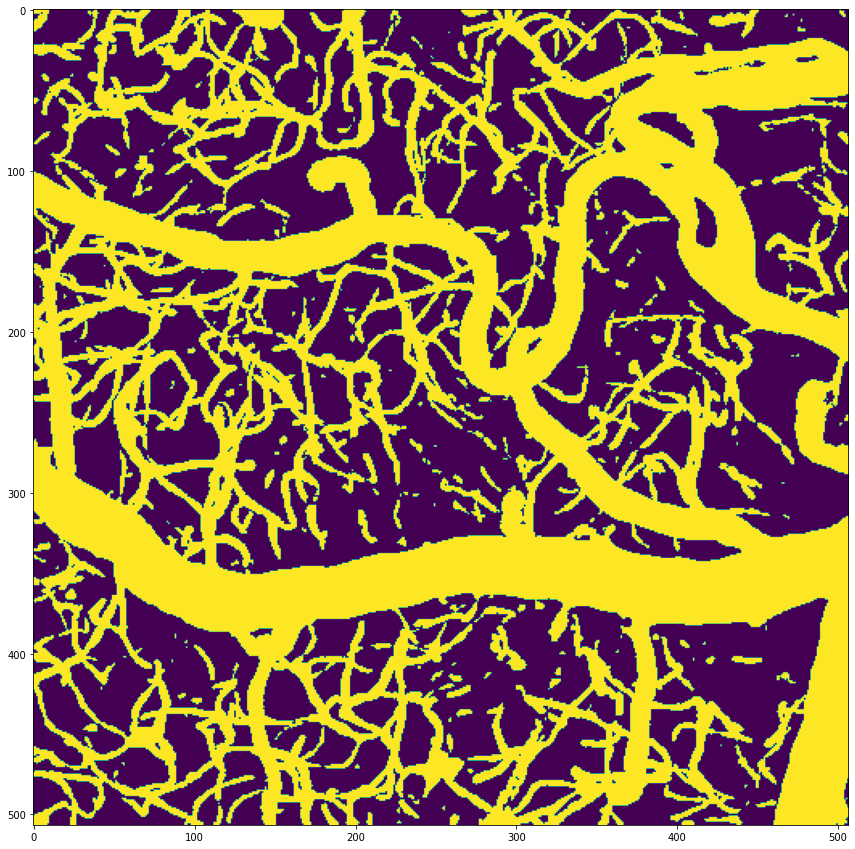

In [67]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(np.max(seg,axis=0))

In [ ]:
restoration.richardson_lucy(img_0001[0]/np.max(img_0001[0]), d, iterations=5)

In [ ]:
deconv_img_0001

In [10]:
#i=341
path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
_pred_radii = np.mean(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
_pred_radii_max = np.max(seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
if _pred_radii == 0:
    _pred_radii =1
_pred_radii_0001 = np.mean(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
_pred_radii_max_0001 = np.max(seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]])
if _pred_radii_0001 == 0:
    _pred_radii_0001 =1

a, b, c = np.mgrid[-10:11:1, -10:11:1, -10:11:1]
abc = np.dstack([a.flat,b.flat, c.flat])
mu = np.array([0,0,0])
sigma = np.array([0.636,0.127,0.127])
covariance = np.diag(sigma**2)
d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
d = d.reshape((len(a),len(b),len(c)))
#deconv_img = np.copy(img)
#deconv_img[0] =  1023 * restoration.richardson_lucy(img[0]/1023.0, d, iterations=10)
#deconv_img[1] =  1023 * restoration.richardson_lucy(img[1]/1023.0, d, iterations=10)
#deconv_img = np.int16(deconv_img)
deconv_img_0001 = np.copy(img_0001)
deconv_img_0001[0] =  1023 * restoration.richardson_lucy((img_0001[0]+1e-2)/1023.0, d, iterations=5)
deconv_img_0001[1] =  1023 * restoration.richardson_lucy((img_0001[1]+1e-2)/1023.0, d, iterations=5)
deconv_img_0001 = np.int16(deconv_img_0001)
print(deconv_img_0001)
break

_box_fit = max([np.int16(_pred_radii_max)+5, np.int16(_pred_radii_max_0001)+5, 10])
#path_grad = np.gradient(path,edge_order=2)[0]
path_smooth = np.float32(np.copy(path))
for k in range(len(path[0])):
    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),2,mode='nearest')
path_grad = np.gradient(path_smooth,edge_order=2)[0]
res_fwhm = []
res_fwhm_0001 = []
X = np.arange(-1*_box_fit,_box_fit+1,1)
Y = np.arange(-1*_box_fit,_box_fit+1,1)
x,y = np.meshgrid(X,Y)
x = x.flatten()
y = y.flatten()
z = np.zeros(len(x))
xy = np.vstack([x,y,z])

def calc_fwhm_path(I):
    point_grad = path_grad[I]
    point = path[I]
    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
        rotated = xy.T + point
    else:
        rotated = _rotmat(point_grad,xy.T) + point
    points = sp.ndimage.map_coordinates(deconv_img[0]-deconv_img[1],
                                        rotated.T, 
                                        order=1,
                                        cval=-10000)
    points_0001 = sp.ndimage.map_coordinates(deconv_img_0001[0]-deconv_img_0001[1],
                                             rotated.T, 
                                             order=1,
                                             cval=-10000)
    popt,pcov = sp.optimize.curve_fit(twoD_Gaussian, 
                                      xy[0:2, points!=-10000], 
                                      points[points!=-10000], 
                                      p0=([np.max(points[points!=-10000])-np.mean(points[points!=-10000]),
                                           max([_pred_radii, _pred_radii_0001]),
                                           0,
                                           0,
                                           np.mean(points[points!=-10000])]),
                                      bounds = ((-1023, 1e-4, -1*_pred_radii/2, -1*_pred_radii/2, -1023), 
                                                (1023, _pred_radii_max*5/(2*np.sqrt(2*np.log(2))), _pred_radii/2, _pred_radii/2, 1023)),
                                      maxfev=10000
                                     )
    popt_0001,pcov_0001 = sp.optimize.curve_fit(twoD_Gaussian, 
                                                xy[0:2, points_0001!=-10000], 
                                                points_0001[points_0001!=-10000], 
                                                p0=([np.max(points_0001[points_0001!=-10000])-np.mean(points_0001[points_0001!=-10000]),
                                                     max([_pred_radii, _pred_radii_0001]),
                                                     0,
                                                     0,
                                                     np.mean(points_0001[points_0001!=-10000])]),
                                                bounds = ((-1023, 1e-4, -1*_pred_radii_0001/2, -1*_pred_radii_0001/2, -1023), 
                                                          (1023, _pred_radii_max_0001*5/(2*np.sqrt(2*np.log(2))), _pred_radii_0001/2, _pred_radii_0001/2, 1023)),
                                                maxfev=10000
                                               )
    sigma = popt[1]
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    fwhm_sigma = pcov[1,1] * 2*np.sqrt(2*np.log(2))
    sigma_0001= popt_0001[1]
    fwhm_0001 = 2*np.sqrt(2*np.log(2))*sigma_0001
    fwhm_sigma_0001 = pcov_0001[1,1] * 2*np.sqrt(2*np.log(2))
    return fwhm, fwhm_0001, fwhm_sigma, fwhm_sigma_0001

pool = multiprocessing.Pool(16)
res_fwhm, res_fwhm_0001, res_fwhm_sigma, res_fwhm_sigma_0001  = zip(*pool.map(calc_fwhm_path, range(len(path))))

[[[[446 472 493 ... 385 421 484]
   [267 241 245 ... 412 359 430]
   [283 275 286 ... 348 318 278]
   ...
   [242 171 197 ... 150 116 139]
   [332 254 135 ... 212 214 188]
   [254 264 180 ... 158 313 242]]

  [[607 643 667 ... 455 500 628]
   [377 359 362 ... 456 401 511]
   [376 373 380 ... 391 382 297]
   ...
   [264 210 282 ... 215 143 159]
   [344 294 195 ... 311 295 247]
   [344 300 252 ... 219 426 325]]

  [[647 687 694 ... 418 458 525]
   [452 512 504 ... 446 389 467]
   [370 398 373 ... 378 345 301]
   ...
   [171 164 272 ... 145 129 167]
   [199 209 186 ... 200 218 200]
   [316 211 232 ... 159 325 252]]

  ...

  [[ 69  79 186 ...  82 148  64]
   [100 108  69 ... 105  66 103]
   [144  84  48 ...  84  75 175]
   ...
   [ 81  95 136 ...  96  86  43]
   [ 60 116 114 ...  83  90  81]
   [ 59  44  50 ...  65 123 126]]

  [[ 51  59 140 ...  81 122  74]
   [ 75  81  52 ... 177  73 140]
   [108  63  36 ... 111  71 211]
   ...
   [ 63  84  86 ... 111 114  49]
   [ 53  74  81 ...  81 10

SyntaxError: 'break' outside loop (3834423542.py, line 28)

In [ ]:
#

In [11]:
#_box_fit = max([np.int16(_pred_radii)+20, np.int16(_pred_radii)+20, 25])
#path_grad = np.gradient(path,edge_order=2)[0]
path_smooth = np.float32(np.copy(path))
for k in range(len(path[0])):
    path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),2,mode='nearest')
path_grad = np.gradient(path_smooth,edge_order=2)[0]
res_fwhm = []
res_fwhm_0001 = []
X = np.arange(-1*_box_fit,_box_fit+1,1)
Y = np.arange(-1*_box_fit,_box_fit+1,1)
x,y = np.meshgrid(X,Y)
x = x.flatten()
y = y.flatten()
z = np.zeros(len(x))
xy = np.vstack([x,y,z])

res_fwhm = []
res_fwhm_0001 = []

res_fwhm_sigma = []
res_fwhm_sigma_0001 = []

for I in tqdm(range(len(path))):
    if I==40:
        break
    point_grad = path_grad[I]
    point = path[I]
    if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
        rotated = xy.T + point
    else:
        rotated = _rotmat(point_grad,xy.T) + point
    points = sp.ndimage.map_coordinates(deconv_img[0]-deconv_img[1],
                                        rotated.T, 
                                        order=1,
                                        cval=-10000)
    points_0001 = sp.ndimage.map_coordinates(deconv_img_0001[0]-deconv_img_0001[1],
                                             rotated.T, 
                                             order=1,
                                             cval=-10000)
    popt,pcov = sp.optimize.curve_fit(twoD_Gaussian, 
                                      xy[0:2, points!=-10000], 
                                      points[points!=-10000], 
                                      p0=([np.max(points[points!=-10000])-np.mean(points[points!=-10000]),
                                           max([_pred_radii, _pred_radii_0001]),
                                           0,
                                           0,
                                           np.mean(points[points!=-10000])]),
                                      bounds = ((-1023, 1e-4, -1*_pred_radii/3, -1*_pred_radii/3, -1023), 
                                                (1023, _pred_radii_max*8/(2*np.sqrt(2*np.log(2))), _pred_radii/3, _pred_radii/3, 1023)),
                                      maxfev=10000
                                     )
    popt_0001,pcov_0001 = sp.optimize.curve_fit(twoD_Gaussian, 
                                                xy[0:2, points_0001!=-10000], 
                                                points_0001[points_0001!=-10000], 
                                                p0=([np.max(points_0001[points_0001!=-10000])-np.mean(points_0001[points_0001!=-10000]),
                                                     max([_pred_radii, _pred_radii_0001]),
                                                     0,
                                                     0,
                                                     np.mean(points_0001[points_0001!=-10000])]),
                                                bounds = ((-1023, 1e-4, -1*_pred_radii_0001/3, -1*_pred_radii_0001/3, -1023), 
                                                          (1023, _pred_radii_max_0001*8/(2*np.sqrt(2*np.log(2))), _pred_radii_0001/3, _pred_radii_0001/3, 1023)),
                                                maxfev=10000
                                               )
    sigma = popt[1]
    fwhm = 2*np.sqrt(2*np.log(2))*sigma
    fwhm_sigma = pcov[1,1] * 2*np.sqrt(2*np.log(2))
    sigma_0001= popt_0001[1]
    fwhm_0001 = 2*np.sqrt(2*np.log(2))*sigma_0001
    fwhm_sigma_0001 = pcov_0001[1,1] * 2*np.sqrt(2*np.log(2))
    #print(fwhm)
    #print(I)
    res_fwhm.append(fwhm)
    res_fwhm_0001.append(fwhm_0001)
    res_fwhm_sigma.append(fwhm_sigma)
    res_fwhm_sigma_0001.append(fwhm_sigma_0001)
    if I ==5:
        break

  7%|▋         | 5/76 [00:00<00:05, 12.76it/s]


In [50]:
point = np.array(np.arange(0,5,0.25))
zeros = np.zeros(len(point))
point = np.array([point,zeros])
point.shape

(2, 20)

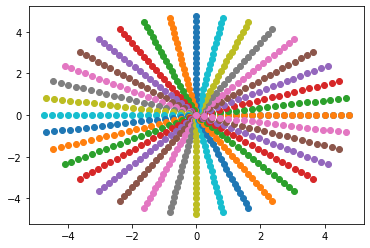

In [52]:
#point = np.array(np.arange(0,5,0.3))
plt.scatter(*point)
for deg in np.arange(0,360,10):
    rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),point)
    #print(rot_point)
    plt.scatter(*rot_point)
    img2 = np.reshape(points,(len(X),len(Y)))
    points_vals = sp.ndimage.map_coordinates(img2,
                                             rotated.T, 
                                             order=1,
                                             cval=-10000)

In [55]:
len(X)//2+1

11

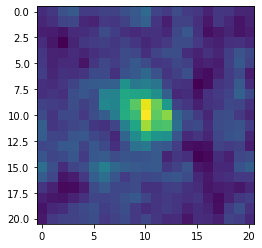

In [63]:
plt.imshow(img2)

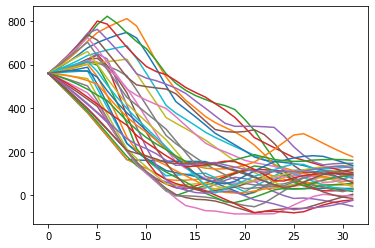

In [62]:
point = np.array(np.arange(0,8,0.25))
zeros = np.zeros(len(point))
point = np.array([point,zeros])
point.shape
#point = np.array(np.arange(0,5,0.3))
#plt.scatter(*point)
for deg in np.arange(0,360,10):
    rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),point) + len(X)//2 + 1
    #print(rot_point)
    #plt.scatter(*rot_point)
    img2 = np.reshape(points,(len(X),len(Y)))
    points_vals = sp.ndimage.map_coordinates(img2,
                                             rot_point, 
                                             order=1,
                                             cval=-10000)
    plt.plot(points_vals)
plt.show()

In [42]:
np.array([[np.cos(deg*(np.pi/180)),-1*np.sin(deg*(np.pi/180))],[np.sin(deg*(np.pi/1802)),np.cos(deg*(np.pi/180))]])

array([[0.9998477 , 0.01745241],
       [0.5858089 , 0.9998477 ]])

In [12]:
((-1023, 1e-4, -1*_pred_radii_0001/3, -1*_pred_radii_0001/3, -1023), 
(1023, max([_pred_radii_max_0001, _pred_radii_max])*5/(2*np.sqrt(2*np.log(2))), _pred_radii_0001/3, _pred_radii_0001/3, 1023))

((-1023, 0.0001, -0.7765622676423641, -0.7765622676423641, -1023),
 (1023, 6.714478388361981, 0.7765622676423641, 0.7765622676423641, 1023))

In [13]:
([np.max(points_0001[points_0001!=-10000])-np.mean(points_0001[points_0001!=-10000]),
                                                     max([_pred_radii, _pred_radii_0001]),
                                                     0,
                                                     0,
                                                     np.mean(points_0001[points_0001!=-10000])])

[555.936507936508, 2.3296868029270925, 0, 0, 58.06349206349206]

In [14]:
deconv_img_0001 = np.copy(img_0001)
deconv_img_0001[0] =  1023 * restoration.richardson_lucy(img_0001[0]/1023, d, iterations=10,clip=False)
deconv_img_0001[1] =  1023 * restoration.richardson_lucy(img_0001[1]/1023, d, iterations=10,clip=False)
deconv_img_0001 = np.int16(deconv_img_0001)

In [15]:
deconv_img_0001[0]

array([[[434, 460, 480, ..., 377, 412, 467],
        [261, 237, 241, ..., 406, 353, 420],
        [275, 268, 278, ..., 343, 310, 276],
        ...,
        [234, 165, 189, ..., 142, 112, 138],
        [323, 246, 129, ..., 198, 204, 181],
        [246, 256, 173, ..., 150, 299, 232]],

       [[632, 668, 694, ..., 472, 519, 662],
        [389, 367, 371, ..., 469, 414, 533],
        [392, 388, 397, ..., 403, 398, 304],
        ...,
        [278, 222, 297, ..., 230, 150, 163],
        [362, 309, 206, ..., 334, 314, 260],
        [361, 315, 265, ..., 233, 453, 345]],

       [[628, 666, 672, ..., 402, 440, 501],
        [441, 502, 494, ..., 431, 376, 448],
        [356, 385, 359, ..., 364, 331, 291],
        ...,
        [162, 157, 262, ..., 137, 125, 162],
        [187, 199, 179, ..., 187, 206, 191],
        [303, 200, 223, ..., 151, 307, 239]],

       ...,

       [[ 71,  82, 195, ...,  79, 145,  61],
        [105, 113,  72, ...,  98,  64,  98],
        [152,  89,  49, ...,  80,  73, 167

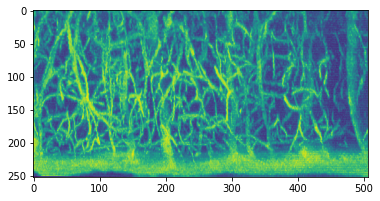

In [16]:
plt.imshow(np.max(np.int16(deconv_img_0001[0]-deconv_img_0001[1]),axis=1))

In [ ]:
#deconv_img

In [ ]:
np.mean(res_fwhm_0001)

In [ ]:
np.mean(res_fwhm)

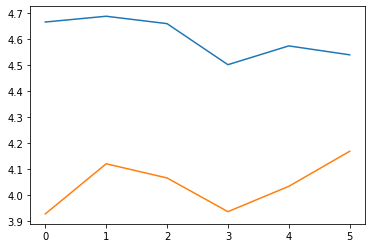

In [17]:
plt.plot(res_fwhm)
plt.plot(res_fwhm_0001)

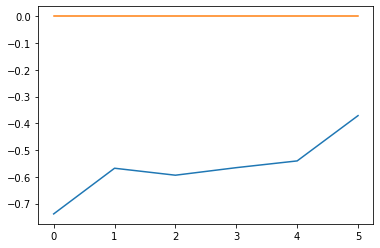

In [18]:
plt.plot(np.array(res_fwhm_0001) - np.array(res_fwhm))
plt.plot(np.zeros(len(res_fwhm)))

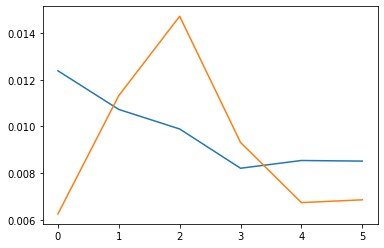

In [19]:
plt.plot(res_fwhm_sigma)
plt.plot(res_fwhm_sigma_0001)

In [ ]:
fwhm

In [ ]:
fwhm_0001

In [ ]:
path_grad

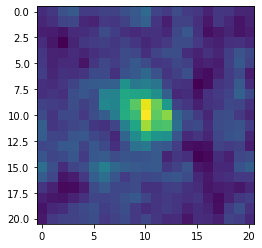

In [20]:
plt.imshow(np.reshape(points,(len(X),len(Y))))

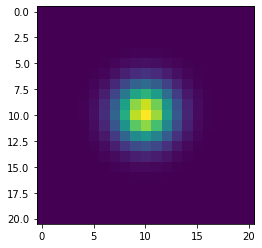

In [21]:
plt.imshow(np.reshape(twoD_Gaussian(xy[0:2],*popt),(len(X),len(Y))))

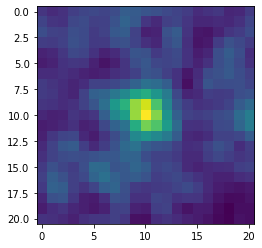

In [22]:
plt.imshow(np.reshape(points_0001,(len(X),len(Y))))

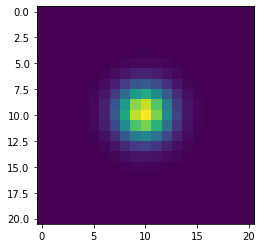

In [23]:
plt.imshow(np.reshape(twoD_Gaussian(xy[0:2],*popt_0001),(len(X),len(Y))))

In [ ]:
_img_0001 = io.imread(img_0001_file)
img_0001 = np.zeros(img.shape)
img_0001[0] = _img_0001[:,:,:507]
img_0001[1] = _img_0001[:,:,508:1015]

print(img_0001.shape)
#img_0001 = np.reshape(img_0001,(252,507,507))
#img_0001.shape
img.shape

In [ ]:
popt_0001

In [ ]:
plt.imshow(np.int16(img_0001[0,20,:,:]))

In [ ]:
plt.imshow(seg[20])

In [ ]:
np.zeros([len(x),len(y)]).shape

In [ ]:
rotated = _rotmat(point_grad,xy.T)
rotated[:,0]*1+rotated[:,1]*1.5+rotated[:,2]

In [ ]:
print(nrn_dst.shape)
print(seg_dst.shape)

In [ ]:
graphs = [file for file in files if not os.path.exists(re.sub('preds','preds_graphs',re.sub('.pickle','_radii.pickle',file)))]
print(len(graphs))

In [ ]:
i=0
xls = pd.ExcelFile('TBI_STIM_metalog_local.xlsx')
df = {}
for sheet_name in xls.sheet_names:
    df[sheet_name] = xls.parse(sheet_name)

for file in tqdm(graphs):
    #if not os.path.exists(re.sub('preds','preds_graphs',re.sub('.pickle','_radii.pickle',file))):
        graph = nx.read_gpickle(file)
        if len(graph.edges) < 1500:
            for sheet_name in xls.sheet_names:
                if re.sub('matt_preds/','',re.sub('_warped.pickle','',file)).split('-')[1] in df[sheet_name].values:
                    subj = sheet_name
                    if re.sub('matt_preds/','',re.sub('_warped.pickle','',file)).split('-')[0].split('_')[1] in sheet_name:
                        if subj in ["TBI07_3D",
                                    "TBI11_3D",
                                    "TBI22_3D",
                                    "TBI31_3D",
                                    "TBI38_3D",
                                    "SHAM09_3D",
                                    "SHAM12_3D",
                                    "SHAM23_3D",
                                    "SHAM32_3D",
                                    'TBI38_3D',
                                    'TBI6_3D',
                                    'SHAM7_3D',
                                    'TBI43_3D',
                                    'TBI45_3D',
                                    'SHAM53_3D',
                                    'SHAM56_3D',
                                    'SHAM55_3D']:
                            gender = 'male'
                        else:
                            gender = 'female'
                        treatment = re.sub('SHA','SHAM',subj[0:3])
                        _tmp = df[subj].loc[df[subj]['CHECK WATER'] == re.sub('matt_preds/','',re.sub('_warped.pickle','',file)).split('-')[1]]
                        if _tmp['Unnamed: 10'].iloc[0] == 2:
                            seg_file = re.sub('_warped.pickle','_seg_warped.tif',file)
                            seg_0001_file = re.sub('_warped.pickle','_0001_seg_warped.tif',file)
                            seg = io.imread(seg_file)
                            seg_0001 = io.imread(seg_0001_file)
                            seg_dst = distance_transform_edt(seg)
                            seg_0001_dst = distance_transform_edt(seg_0001)
                            nrn_dst = np.load(re.sub('_warped.pickle','_seg_nrn_dst.npy',file))
                            nrn_dst = np.swapaxes(nrn_dst,0,2)
                            start_depth = _tmp['Unnamed: 2'].iloc[0]
                            age = _tmp['Unnamed: 8'].iloc[0]
                            days_post_injury = _tmp['Unnamed: 9'].iloc[0]
                            for i in range(len(graph.edges)):
                                path = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['pts']
                                _vals = seg_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                _vals_0001 = seg_0001_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                _nrn_dst_vals = nrn_dst[path[::-1,0],path[::-1,1],path[::-1,2]]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii'] = np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_std'] = np.std(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_0001'] = np.mean(_vals_0001)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['radii_0001_std'] = np.std(_vals_0001)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_neuron_distance'] = np.mean(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_std'] = np.std(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['neuron_distance_min'] = np.min(_nrn_dst_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['delta'] = np.mean(_vals_0001) - np.mean(_vals)
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['gender'] = gender
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights'] = _vals
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['path_weights_0001'] = _vals_0001
                                #graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight'] = graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['weight']
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0z'] = path[0][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0y'] = path[0][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-0x'] = path[0][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1z'] = path[-1][0]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1y'] = path[-1][1]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['end-1x'] = path[-1][2]
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['img_start_depth'] = start_depth
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['mean_depth'] = np.mean(path[:,0])
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['euclidean-dst'] = np.sqrt(np.sum(np.square(path[-1]-path[0])))
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['subject'] = subj
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['treatment'] = treatment
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['age'] = age
                                graph[list(graph.edges)[i][0]][list(graph.edges)[i][1]]['days_post_injury'] = days_post_injury
                            nx.write_gpickle(graph, re.sub('preds','preds_graphs',re.sub('.pickle','_radii_shock.pickle',file)))
                            i+=1
print(i)

In [ ]:
_graphs = [file for file in graphs if not os.path.exists(re.sub('preds','preds_graphs',re.sub('.pickle','_radii_shock.pickle',file)))]
print(len(_graphs))
print(_graphs)

# convert graphs to excel files

In [ ]:
directory = Path('matt_preds_graphs_fwhm')
files = directory.glob('*_warped_radii.pickle')
files = sorted([x.as_posix() for x in files])
print(len(files))
files[0]

In [ ]:
#edge_df

In [ ]:
res=[]
for file in tqdm(files):
    graph = nx.read_gpickle(file)
    edge_df = nx.to_pandas_edgelist(graph)
    if edge_df.shape[1] == 32:
        edge_df.to_excel(re.sub('.pickle','.xlsx',file))
        res.append(len(edge_df))
    print(edge_df.shape)
#print(np.mean(res))
#print(np.std(res))

In [ ]:
file

In [ ]:
edge_df.shape[1]

In [ ]:
directory = Path('matt_preds_graphs_fwhm')
files = directory.glob('*_warped_radii_shock.pickle')
files = sorted([x.as_posix() for x in files])
print(len(files))
files[0]

In [ ]:
for file in tqdm(files):
    graph = nx.read_gpickle(file)
    edge_df = nx.to_pandas_edgelist(graph)
    if edge_df.shape[1] == 30:
        edge_df.to_excel(re.sub('.pickle','.xlsx',file))
        print(edge_df.shape)